In [2]:
# Parallelität
import multiprocessing

# Kommunkation mit Betriebssystem
import os

# Reguläre Ausdrücke
import re

# NLP
import nltk

# Word2Vec von Gensim
import gensim.models.word2vec as w2v

# Dimensionsverminderung
import sklearn.manifold

# Plot von Matplotlib
import matplotlib.pyplot as plt

# DatasetParser
import pandas as pd

# Kommunikation mit Mongo DB
import pymongo

In [4]:
# Order, wo dieses Jupyter-Notebook befindet
current_path=os.getcwd()

#print(current_path)

In [5]:
db_server = '141.45.146.247'
db_port= 27017

client = pymongo.MongoClient(db_server, db_port)

In [6]:
gr1_collection = client.gruppe1.articles

artikels=gr1_collection.find()
#print(artikels.count())

In [7]:
myFirst=artikels[0]

In [8]:
def getData(file, key):
   return file[key]

In [9]:
text1=getData(myFirst, 'text')
print(text1)

EU-Justizkommissarin Vera Jourova hat vor einer zunehmenden Beeinflussung von Wählern im Internet gewarnt. „Die Online–Medien sind eine ’Black box’“, sagte Jourova am Dienstag in Berlin. In dieser Situation müssten die EU-Staaten den Bürgern die Freiheit der Wahlentscheidungen garantieren. Dies gelte auch für den Fall, dass legal erworbene Nutzerdaten bei Wahlkampagnen verwendet würden, sagte Jourova.Jourova hielt sich in Berlin auf, um knapp zwei Wochen vor dem Inkrafttreten der europäischen Datenschutz-Grundverordnung am 25. Mai politische Gespräche unter anderem mit Justizministerin Katarina Barley (SPD) und der Digital-Staatsministerin Dorothee Bär (CSU) zu führen. Der Datenskandal um Facebook und Cambridge Analytica, von dem auch 2,7 Millionen EU-Bürger betroffen waren, sei ein Weckruf für den Datenschutz, sagte Jourova. Angesichts des Skandals, bei dem Nutzerdaten unerlaubt für die Kampagne des heutigen US-Präsidenten Donald Trump verwendet worden sein sollen, stelle sich die Fra

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(text1)
#print(raw_sentences)

In [12]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
#print(sentences)

In [14]:
token_count = sum([len(sentence) for sentence in sentences])
print("The article corpus contains {0:,} tokens".format(token_count))

The article corpus contains 203 tokens


In [15]:
# Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300

#
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 2

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [16]:
article2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [17]:
article2vec.build_vocab(sentences)

In [18]:
print("Word2Vec vocabulary length:", len(article2vec.wv.vocab)) # Achtung!

Word2Vec vocabulary length: 143


In [19]:
#train model on sentneces
article2vec.train(sentences, total_examples=article2vec.corpus_count, epochs=article2vec.epochs)

(514, 1015)

In [20]:
model_path = "trained"
if not os.path.exists(current_path+"/"+model_path):
    os.makedirs(current_path+"/"+model_path)

model_name = "article2vec.w2v"
article2vec.save(current_path+"/"+model_path+"/"+model_name)

In [21]:
article2vec = w2v.Word2Vec.load(current_path+"/"+model_path+"/"+model_name)

In [22]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [23]:
%%time
all_word_vectors_matrix = article2vec.wv.vectors #Achtung

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 18.1 µs


In [60]:
#print(all_word_vectors_matrix)

In [24]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [25]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[article2vec.wv.vocab[word].index])
            for word in article2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [26]:
%%time
points.head(20)

CPU times: user 482 µs, sys: 67 µs, total: 549 µs
Wall time: 558 µs


,word,x,y
0,EU,5.308983,-2.753000
1,Justizkommissarin,5.052724,1.555744
2,Vera,-1.289725,-3.400242
3,Jourova,1.652489,-1.025158
4,hat,3.694029,1.033950
5,vor,-3.136167,-0.052709
6,einer,3.661311,-1.255546
7,zunehmenden,6.314854,0.903502
8,Beeinflussung,2.304256,0.010765
9,von,-2.814842,0.286160


In [27]:
#sns.set_context("poster")

CPU times: user 53.9 ms, sys: 5.69 ms, total: 59.6 ms
Wall time: 58.4 ms


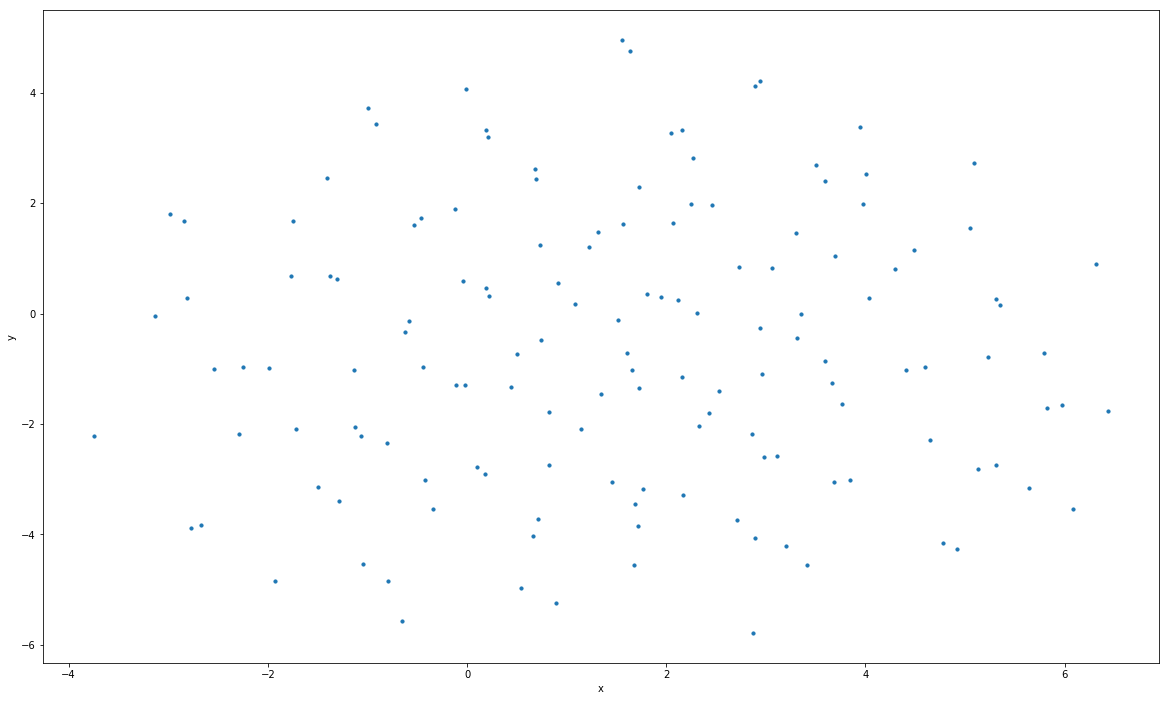

In [28]:
%%time

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [29]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) & (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) & (points.y <= y_bounds[1]) 
    ]
    
    print(slice)
    
    if(slice.empty):
        print("DataFrame is empty. Please choose other x/y")
    else:
        ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

                   word         x         y
8         Beeinflussung  2.304256  0.010765
9                   von -2.814842  0.286160
30                    m  2.731057  0.850506
33              Staaten  2.070332  1.634050
38                  der -1.749065  1.684450
39   Wahlentscheidungen  1.812083  0.349969
45                    r -2.980986  1.795616
47                 dass -0.534732  1.605109
60                knapp  0.735563  1.243354
73                unter  0.220062  0.326158
74              anderem -0.124415  1.898580
75                  mit  1.088074  0.169136
85                   zu  1.565624  1.628767
90            Cambridge -1.767631  0.673592
91            Analytica -0.037135  0.580966
93                 rger  0.187188  0.463276
98              Weckruf  2.114766  0.240531
106                  Pr  0.912856  0.549429
109               Trump -1.305773  0.618845
116              Wahlen  1.315571  1.479399
123           Kampagnen  2.250563  1.985013
129                  re -2.84275

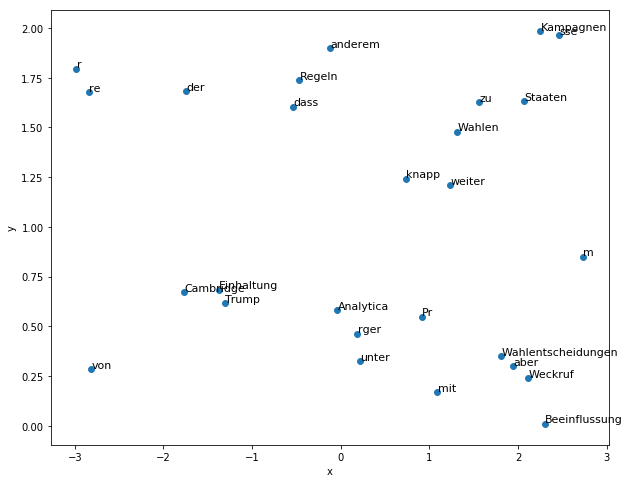

In [30]:
plot_region(x_bounds=(-3, 3), y_bounds=(0, 2))

In [31]:
article2vec.wv.most_similar("Frage")

[('Katarina', 0.11590475589036942),
 ('sonst', 0.10558962821960449),
 ('waren', 0.10504832863807678),
 ('Wahlkampagnen', 0.10477922111749649),
 ('ssten', 0.09456422924995422),
 ('dass', 0.08733183145523071),
 ('Black', 0.07918941229581833),
 ('sidenten', 0.0771758183836937),
 ('Medien', 0.07688486576080322),
 ('hielt', 0.07207708060741425)]

In [32]:
article2vec.wv.similarity('Frage', 'Transparenz')

-0.05293437802937577

In [35]:
import numpy as np
from scipy import spatial

In [38]:
index2word_set = set(article2vec.wv.index2word)

In [57]:
def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [59]:
tt1="Ein Fernsehgerät oder Fernsehapparat, in den 1930er Jahren auch Ferntonkino oder das Telehor (von altgriechisch horao = ‚sehen‘), ist ein Gerät zum Empfang und zur Wiedergabe von analogen und digitalen Fernsehsignalen. Die Idee für einen ersten mechanischen Fernsehapparat wurde bereits 1886 von Paul Nipkow in einem Patent dargelegt. Er gilt damit als der eigentliche Erfinder des Fernsehens. Gebräuchlich für Fernsehgeräte ist auch die Bezeichnung Fernsehempfänger."
tt2="Die Sonne ist der Stern im Zentrum des Sonnensystems. Sie ist ein durchschnittlich großer Stern im äußeren Drittel der Milchstraße. Die Sonne ist ein Hauptreihen­stern (Zwergstern). Sie enthält 99,86 % der gesamten Masse des Sonnensystems und hat einen Durchmesser von 1,4 Millionen Kilometern, dem 109-fachen der Erde."

s1_afv = avg_feature_vector(tt1, model=article2vec, num_features=300, index2word_set=index2word_set)
s2_afv = avg_feature_vector(tt2, model=article2vec, num_features=300, index2word_set=index2word_set)
sim = 1 - spatial.distance.cosine(s1_afv, s2_afv)
print(sim)

0.5805947780609131


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
